### Import the Libraries

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import Xception
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Specify the three Directory Paths
##### These paths are used to specify the directories where the training, testing, and validation datasets are located, respectively.

In [27]:
train_dir = 'data/train'
test_dir = 'data/test'
validation_dir = 'data/validation'

### Define instances of the ImageDataGenerator
##### These generators are used to perform data augmentation and preprocessing on images before they are fed into the model during training, validation, and testing phases.

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

### Initialize the generators
##### These generators are used to load and preprocess images directly from directories and yield batches of augmented images during model training, validation, and testing phases.

In [29]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 2800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Extract Class Names
##### Obtain a list of class names corresponding to the labels present in the training dataset.

In [30]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['broken', 'good']



### Initialization of Xception Base Model

In [31]:
base_model = Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


### Freezing Layers in a Pre-trained Model
##### Freezing layers is a common technique when fine-tuning pre-trained models for transfer learning tasks. It allows you to retain the learned features in the earlier layers of the model while only training the top layers (usually added for specific tasks) with new data. This can help prevent overfitting, reduce training time, and improve performance when working with limited data.

In [32]:
for layer in base_model.layers:
    layer.trainable = False

### Feature Extraction using Pre-trained Model for Image Classification
##### Extract features from images which are used as input to train the Random Forest Classification for image classification.

In [33]:
train_features = base_model.predict(train_generator)
validation_features = base_model.predict(validation_generator)
test_features = base_model.predict(test_generator)

c:\Users\noora\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step


### Flattening Extracted Features from Xception
##### This code snippet flattens the extracted features obtained from the Xception model. When images are passed through the Xception, the output features from the last convolutional layer or the global pooling layer are obtained. These features are often in a multi-dimensional format (e.g., a tensor), where each dimension represents different aspects or representations of the input images. However, for feeding these features into a classifier such as a Random Forest, it's necessary to flatten them into a one-dimensional array. This flattening operation transforms the multi-dimensional features into a single vector, where each element represents a specific feature or characteristic learned by the Xception model.

In [34]:
train_features_flatten = train_features.reshape(train_features.shape[0], -1)
validation_features_flatten = validation_features.reshape(validation_features.shape[0], -1)
test_features_flatten = test_features.reshape(test_features.shape[0], -1)

### Extracting Class Labels from Image Data Generators

In [35]:
train_labels = train_generator.classes
validation_labels = validation_generator.classes
test_labels = test_generator.classes

### Random Forest Classifier Training
##### Training a Random Forest classifier on the extracted features from the training dataset. The classifier is configured with 100 decision trees and a random seed of 42. the classifier is trained on the flattened features extracted from the training dataset and their corresponding labels.

In [36]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features_flatten, train_labels)

RandomForestClassifier(random_state=42)

### Predictions using Random Forest Classifier

In [37]:
train_predictions = rf_classifier.predict(train_features_flatten)
validation_predictions = rf_classifier.predict(validation_features_flatten)
test_predictions = rf_classifier.predict(test_features_flatten)

### Evaluation of Model Accuracy on Training, Validation, and Test Datasets
##### Accuracy was chosen as a metric for classifying the hex nuts as defective or non-defective because it provides a straightforward measure of how often the model correctly predicts/classifies the class of an item.

In [38]:
train_accuracy = accuracy_score(train_labels, train_predictions)
validation_accuracy = accuracy_score(validation_labels, validation_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

In [39]:
print("Train Accuracy: {:.2f}%".format(train_accuracy*100))
print("Validation Accuracy: {:.2f}%".format(validation_accuracy*100))
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))


Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Test Accuracy: 98.88%


### Image Classification Prediction using Xception and Random Forest Classifier
##### This function encapsulates the process of making predictions on a single image using a combination of feature extraction with a deep learning model (Xception) and classification with a traditional machine learning model (Random Forest).

In [40]:
def model_predict(img_path, resnet_model, rf_classifier):
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)

    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # Extract features using Xception model
    features = resnet_model.predict(x)

    # Flatten the features
    features_flatten = features.reshape(1, -1)

    # Make predictions using the Random Forest classifier
    preds = rf_classifier.predict(features_flatten)

    if preds == 0:
        plt.xlabel("Defective", fontsize=10)
    else:
        plt.xlabel("Non-Defective", fontsize=10)

    return preds


### Predictions on New Data

data/test/broken/1_2021-11-17 01_06_42.375418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([0])

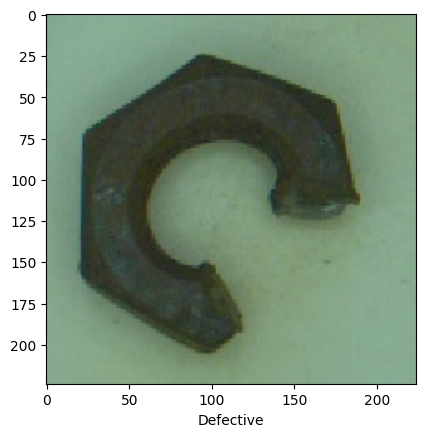

In [41]:
model_predict('data/test/broken/1_2021-11-17 01_06_42.375418.jpg', base_model, rf_classifier)

data/test/good/1_2021-11-15 14_23_44.486304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


array([1])

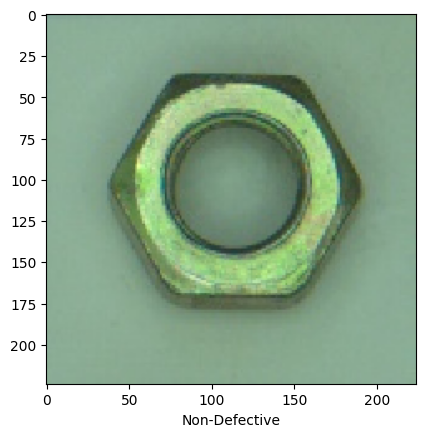

In [42]:
model_predict('data/test/good/1_2021-11-15 14_23_44.486304.jpg', base_model, rf_classifier)

data/test/good/1_2021-11-15 14_24_46.329059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


array([1])

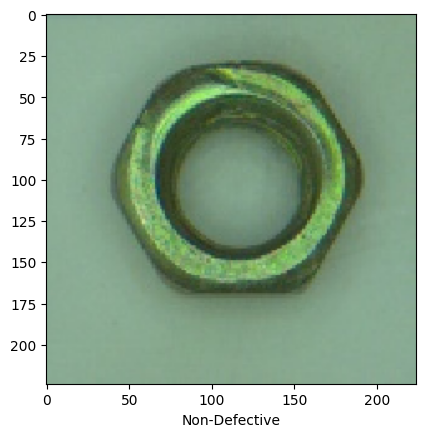

In [43]:
model_predict('data/test/good/1_2021-11-15 14_24_46.329059.jpg', base_model, rf_classifier)

data/test/broken/1_2021-11-17 01_13_13.484720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


array([0])

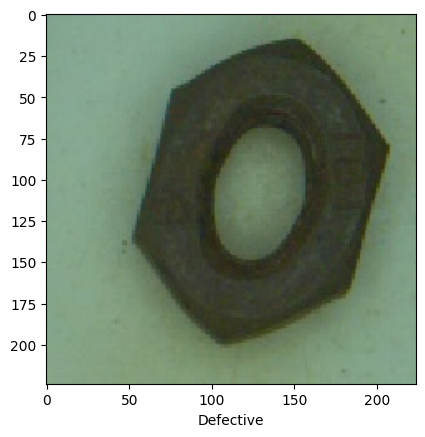

In [44]:
model_predict('data/test/broken/1_2021-11-17 01_13_13.484720.jpg', base_model, rf_classifier)

data/test/broken/1_2021-11-17 01_13_52.278142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


array([0])

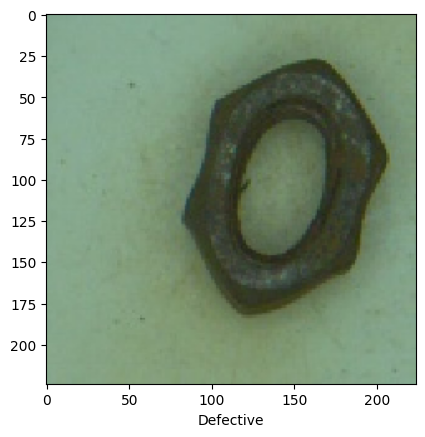

In [46]:
model_predict('data/test/broken/1_2021-11-17 01_13_52.278142.jpg', base_model, rf_classifier)